In [48]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
from scipy.stats import norm

In [49]:
def plot_func(func, x=np.linspace(0,5,3001), logscale=False, ylim=[], xlabel='', ylabel=''):
    y = np.vectorize(func)(x)
    plt.figure(figsize=(5,5))
    axes = plt.gca()
    if logscale: axes.set_yscale('log')
    if len(ylim) == 2: axes.set_ylim(ylim)
    if xlabel: axes.set_xlabel(xlabel)
    if ylabel: axes.set_ylabel(ylabel)
    plt.title(func.__name__)
    plt.plot(x,y)
    plt.show()

In [82]:
# Useful functions

def factorial(x):
    if x == 0:
        return 1
    elif x > 0:
        for i in range(1,int(x)):
            x = x * i
        return x
    
# generate n, m based on inverse CDF of poisson distribution
# CDF gives you the p-value (CL) for a given value of the variable
# inverse of CDF gives you a value of the variable based on the p-value (0<p<1)
# This is why we use random.uniform(0,1) for the p-value
# nexpec, mexpec are the expected values of the poisson 
# (the expected rate where the variable is a function of time, as is common for poisson)

# see https://en.wikipedia.org/wiki/Poisson_distribution             for general poisson info
# see https://en.wikipedia.org/wiki/Cumulative_distribution_function for the CDF
# see https://en.wikipedia.org/wiki/Inverse_transform_sampling       for the method
# see https://www.kite.com/python/docs/scipy.stats.poisson           for documentation

def generate_nm(nexpec,mexpec,numev):
    ngen = [poisson.ppf(random.uniform(0,1),nexpec) for i in range(0,numev)]
    mgen = [poisson.ppf(random.uniform(0,1),mexpec) for i in range(0,numev)]
    return [ngen, mgen]


In [83]:
# Maximum Likelihood estimators for single bin
# tau, mu, s are input parameters and not included here
def mu_max(n,m,s,b,tau,mu): # for maximizing functions of 2 vars, b and mu in denominator of LLR
    return (n - m/tau)/s
def b_max(n,m,s,b,tau,mu): #for maximizing fucntions of 2 vars, b and mu in denominator of LLR
    return m/tau
def b_max1(n,m,s,b,tau,mu): #maximize fxn of 1 var, b, in numerator of LLR--NOTE THAT IT IS A FXN OF mu
    return (n+m-(1+tau)*mu*s)/(2*(1+tau)) + ( ((n+m-(1+tau)*mu*s)**2+4*(1+tau)*m*mu*s) * 0.25/(1+tau)**2 )**0.5


In [84]:
def likelihood(n,m,s,b,tau,mu): # s and tau are the only constants 
    return (mu*s+b)**n / (factorial(n)) * math.exp(-(mu*s+b)) * (tau*b)**m / factorial(m) * math.exp(-tau*b)

def LLR(n,m,s,b,tau,mu):
    return likelihood(n,m,s,b_max1(n,m,s,b,tau,mu),tau,mu)/(likelihood(n,m,s,b_max(n,m,s,b,tau,mu),tau,mu_max(n,m,s,b,tau,mu)))


def q0(n,m,s,b,tau):
    # mu = 0
    if mu_max(n,m,s,b,tau,0) > 0:
        return -2*math.log(LLR(n,m,s,b,tau,0))
    else:
        return 0

    # Expected # of events
def En(s,b,mu):
    return mu*s+b
def Em(b,tau):
    return tau*b
#print(f"En: {En} Em: {Em}")


In [97]:
def sigma(s,b,tau,mup):
    return math.sqrt(mup**2/q0(En(s,b,mup),Em(b,tau),s,b,tau))


def PDFQ0(s,b,tau,mup,q0d):
#    return np.exp(-q0*0.5)*(2*math.sqrt(2*math.pi*q0))**-1
    if q0d <= 0:
        return None
    if mup == 0:
        return np.exp(-q0d*0.5)*(2*math.sqrt(2*math.pi*q0d))**-1
    else:
        return np.exp(-0.5*(q0d**0.5-mup/sigma(s,b,tau,mup))**2)*0.5/math.sqrt(2*math.pi*q0d)

In [86]:
sigma(10,10,1,1)

0.5424872603903432

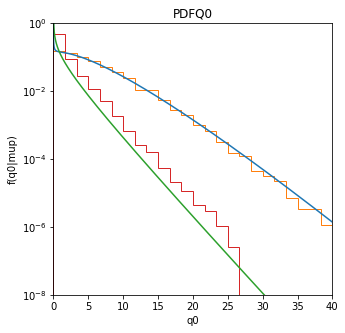

In [105]:
s = 10
b = 10
tau = 1
mup = 1
q0d = np.linspace(0,40,30001)
numevents = 5000000

# choose n and m such that mu hat = 1
# calculate q0 values for all n,m, that satisfy
# q

y = np.vectorize(PDFQ0)(s,b,tau,mup,q0d)

plt.figure(figsize=(5,5))
axes = plt.gca()
logscale: axes.set_yscale('log')
axes.set_ylim(10e-9,1)
axes.set_xlim(0,40)
axes.set_xlabel('q0')
axes.set_ylabel('f(q0|mup)')
plt.title('PDFQ0')
plt.plot(q0d,y)

q0s = []
nm = generate_nm(En(s,b,mup),Em(b,tau),numevents)
for evindex in range(numevents):
    q0val = q0(nm[0][evindex],nm[1][evindex],s,b,tau)
    if q0val != 0:
        q0s.append(q0val)
plt.hist(q0s,bins=24,range=(0,40),density=True,histtype='step')

num_events = 10000000

mup = 0
y = np.vectorize(PDFQ0)(s,b,tau,mup,q0d)
plt.plot(q0d,y)

q0s = []
nm = generate_nm(En(s,b,mup),Em(b,tau),numevents)
for evindex in range(numevents):
    q0val = q0(nm[0][evindex],nm[1][evindex],s,b,tau)
    if q0val != 0:
        q0s.append(q0val)
plt.hist(q0s,bins=24,range=(0,40),density=True,histtype='step')


plt.show()

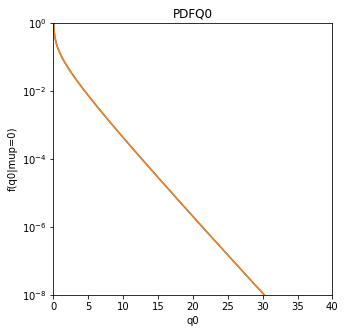

In [100]:
mup = 0
plt.figure(figsize=(5,5))
axes = plt.gca()
logscale: axes.set_yscale('log')
axes.set_ylim(10e-9,1)
axes.set_xlim(0,40)
axes.set_xlabel('q0')
axes.set_ylabel('f(q0|mup=0)')
plt.title('PDFQ0')
plt.plot(q0d,y)
y = np.vectorize(PDFQ0)(s,b,tau,mup,q0d)
plt.plot(q0d,y)